In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
from torchvision import transforms
from data.torch_data_loaders import homography_dataset
from board_detection.homomography_network import HomographyNet
from board_detection.homomography_training import show_perspective_corrected_board
from board_detection.homomography_training import load_dataset
from board_detection.homomography_training import train_model
from board_detection.homomography_training import calculate_test_loss

100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


Epoch [1/2], Loss: 32.0030
Model saved to runs/models/homomography_model.pth


100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


Epoch [2/2], Loss: 27.1854
Model saved to runs/models/homomography_model.pth


100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


100%|██████████| 4/4 [00:25<00:00,  6.42s/it]


Epoch [2/3], Loss: 1053.7034


100%|██████████| 4/4 [00:25<00:00,  6.36s/it]


Epoch [3/3], Loss: 647.1310


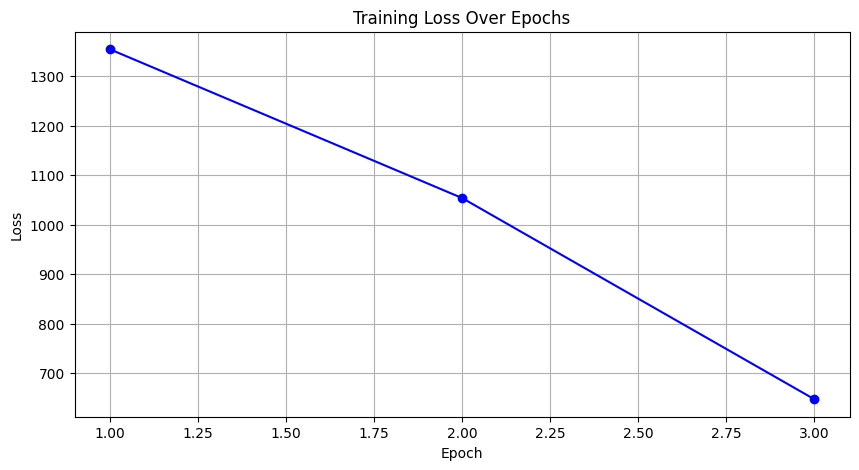

In [3]:
input_transform_pipeline = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor()
])

label_transform_pipeline = transforms.Compose([
    homography_dataset.HomographyOutputTransform((512, 512), (128, 128)),
    transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float32)), 
    transforms.Lambda(lambda x: torch.flatten(x))
])

json_path = 'data/full/perspective_distorted_boards/bbox_coordinates.json'
img_dir = "data/full/perspective_distorted_boards"

dataset = load_dataset(json_path, img_dir, input_transform_pipeline, label_transform_pipeline)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size


train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

learning_rate = 0.001
num_epochs = 10
model = HomographyNet(9) #9 cuz the matrix is flat 3 x 3
criterion = nn.MSELoss()
device = "cpu"
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
save_path = "runs/models/homomography_model.pth"
# resume_path = "runs/models/homomography_model.pth"
resume_path = None


train_losses = train_model(model, train_loader, criterion, optimizer, num_epochs, device, save_path, resume_path)
test_loss = calculate_test_loss(model, test_loader, criterion, device)

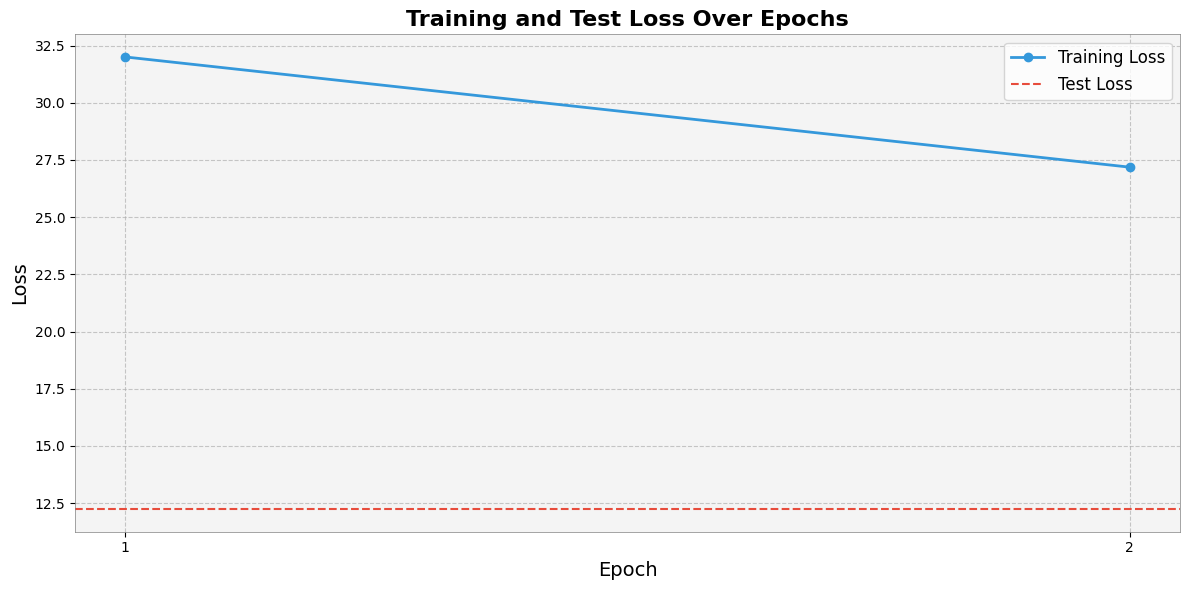

In [9]:
from visualization import show_loss 
show_loss.show_train_test_loss(train_losses, test_loss, num_epochs)

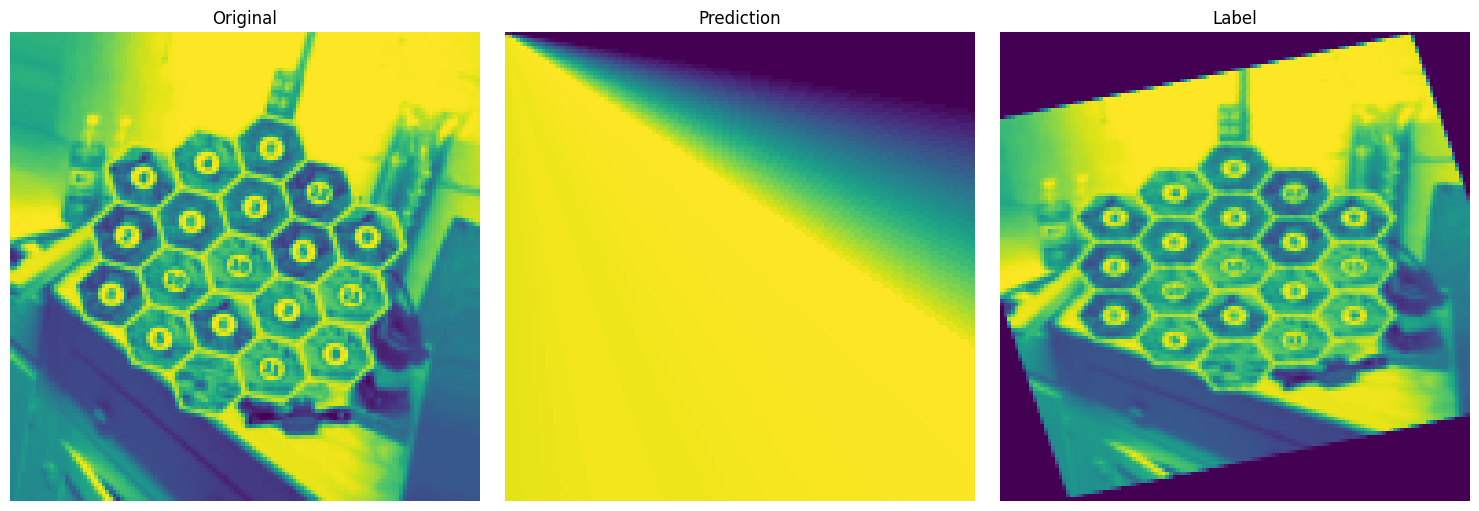

array([[0.04530484, 0.03624387, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.6181066 , 0.5601218 , 0.3529948 , ..., 0.        , 0.        ,
        0.        ],
       [0.6553003 , 0.6613971 , 0.6651961 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.63982844, 0.6404412 , 0.6410539 , ..., 0.6650735 , 0.6653186 ,
        0.6653186 ],
       [0.63982844, 0.6404412 , 0.6410539 , ..., 0.6650735 , 0.6650735 ,
        0.6653186 ],
       [0.63982844, 0.6404412 , 0.6410539 , ..., 0.6650735 , 0.6650735 ,
        0.6650735 ]], dtype=float32)

In [10]:
image, label = dataset.__getitem__(np.random.randint(0, dataset.__len__()))

show_perspective_corrected_board(model, image, label)

[[0.8053774218312283, -0.5573865746195159, 178.47434738746253],
 [0.4406565083135537, 1.0209635790839329, -117.94393911154151],
 [-6.631693634012697e-11, 5.836884631594808e-11, 1.0]]